In [3]:
from datetime import datetime
from IPython.display import Image
datetime.now()

datetime.datetime(2024, 4, 20, 22, 9, 18, 257557)

In [4]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [3]:
# !pip install -U wandb
# !pip install -U accelerate

In [5]:
import transformers
import torch

- grant 申请地址（region 不要选 China？）
    - meta 原始权重：https://llama.meta.com/llama-downloads/
    - hf 版本权重：https://huggingface.co/meta-llama/Meta-Llama-3-8B 
- meta
    - meta 提供的是 weights 以及 inference code，是定制的；
    - https://ai.meta.com/blog/meta-llama-3/
    - https://github.com/meta-llama/llama3
        - llama2 model card: https://github.com/meta-llama/llama/blob/main/MODEL_CARD.md
        - llama3 model card: https://github.com/meta-llama/llama3/blob/main/MODEL_CARD.md
- Huggingface
    - 是拿到了 weights 和 inference code 之后，在 transformers 库中做了适配和兼容；
    - https://huggingface.co/meta-llama/Meta-Llama-3-8B

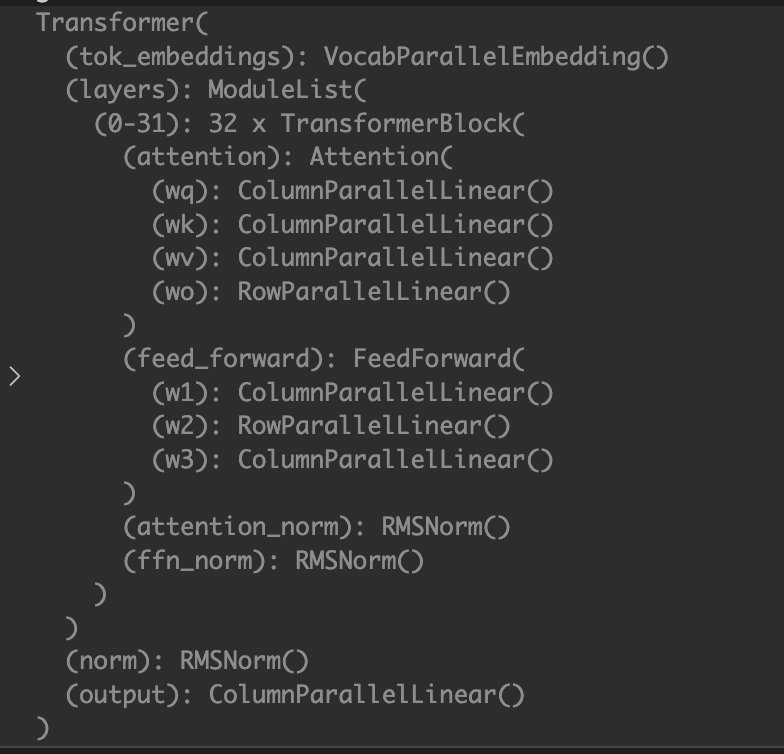

In [2]:
Image('../../imgs/meta-llama-model.png', width=400)

In [5]:
# !pip install blobfile

## basics

In [6]:
'8.03B, {:.2f}GB'.format(8.03 * 1_000_000_000 * 2 / (1024*1024*1024))

'8.03B, 14.96GB'

|     **model**    | **heads** | **layers** | **dim** | **head_dim** |
|------------------|-----------|------------|---------|--------------|
| llama2-7b        | 32        | 32         | 4096    | 4096/32      |
| llama2-13b       | 40        | 40         | 5120    | 5120/40      |
| llama2-70b       | 64        | 80         | 8192    | 8192/64      |

|     **model**    | **heads** | **layers** | **dim** | **head_dim** |
|------------------|-----------|------------|---------|--------------|
| llama3-8b        | 32        | 32         | 4096    | 4096/32      |

- 关于 dtype
    - 默认是 bf16，其次是 float16

```
if torch.cuda.is_bf16_supported():
    torch.set_default_tensor_type(torch.cuda.BFloat16Tensor)
else:
    torch.set_default_tensor_type(torch.cuda.HalfTensor)
```

### performance

- 最强小模型（7B/8B）；
    - 对比 Gemma 7B 和 Mistral 7B
    - 略低于 llama2 70B

### model arch

In [7]:
from transformers import AutoModelForCausalLM

In [8]:
model_id = "meta-llama/Llama-2-7b-hf"
llama2_7b = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

We've detected an older driver with an RTX 4000 series GPU. These drivers have issues with P2P. This can affect the multi-gpu inference when using accelerate device_map.Please make sure to update your driver to the latest version which resolves this.


In [15]:
llama2_7b

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Lin

In [18]:
11008/4096

2.6875

In [22]:
total_params = 0
for name, para in llama2_7b.named_parameters():
    total_params += para.numel()
total_params

6738415616

In [9]:
model_id = "meta-llama/Meta-Llama-3-8B"
llama3_8b = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=torch.float16, device_map="auto")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

We've detected an older driver with an RTX 4000 series GPU. These drivers have issues with P2P. This can affect the multi-gpu inference when using accelerate device_map.Please make sure to update your driver to the latest version which resolves this.


In [16]:
llama3_8b

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head): Li

In [20]:
total_params = 0
for name, para in llama3_8b.named_parameters():
    total_params += para.numel()
total_params

8030261248

In [21]:
8030261248 * 2 / (1024*1024*1024)

14.957527160644531

### tokenizer

- 仍然都是 bpe
- 都是要完成 `prompt_tokens = [self.tokenizer.encode(x, bos=True, eos=False) for x in prompts]`
- llama2：`SentencePieceProcessor`
    - tokenizer is a BPE model based on sentencepiece. 
- llama3：`tiktoken` openai 用 Rust 写的 `tiktoken`
    - num_reserved_special_tokens = 256


In [30]:
# llama2
from sentencepiece import SentencePieceProcessor
sp_model = SentencePieceProcessor(model_file='./llama2_tokenizer.model')
sp_model.vocab_size()

32000

In [10]:
# llama3
from tokenizer import Tokenizer
llama3_tokenizer = Tokenizer('./llama3_tokenizer.model')

In [11]:
llama3_tokenizer.n_words

128256

In [13]:
# llama3_tokenizer.special_tokens

### token_embedding

- 128256 * 4096
- ParallelEmbedding：列分布式（列分块）
    - Embedding parallelized in the embedding dimension.
    - ParallelEmbedding 允许每个模型并行单元处理全词汇的部分维度表示，适用于对词汇表整体进行较密集的操作。
- VocabParallelEmbedding：行分布式（行分块）
    - Embedding parallelized in the vocabulary dimension.
    - VocabParallelEmbedding 允许分散词汇表的处理负载，适用于大词汇表或在内存受限的环境中进行有效处理。

## meta demo

- `vscode`: `launch.json`

```
{
    "configurations": [
        {
            "name": "Python Debugger: Current File",
            "type": "debugpy",
            "request": "launch",
            // "program": "example_text_completion.py",
            "module": "torch.distributed.launch",
            "console": "integratedTerminal",
            "justMyCode": false,
            "args": [
                "--nproc_per_node", "1",
                "example_text_completion.py",
                "--ckpt_dir", "Meta-Llama-3-8B",
                "--tokenizer_path", "Meta-Llama-3-8B/tokenizer.model",
                "--max_seq_len", "512", 
                "--max_batch_size", "6"
            ]
        }
    ]
}
```

## hf demo

In [14]:
model_id = "meta-llama/Meta-Llama-3-8B"

# model-00001-of-00004.safetensors
# model-00002-of-00004.safetensors
# model-00003-of-00004.safetensors
# model-00004-of-00004.safetensors
pipeline = transformers.pipeline("text-generation", 
                                 model=model_id, 
                                 model_kwargs={"torch_dtype": torch.bfloat16}, 
                                 device_map="auto")
pipeline("Hey how are you doing today?")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

We've detected an older driver with an RTX 4000 series GPU. These drivers have issues with P2P. This can affect the multi-gpu inference when using accelerate device_map.Please make sure to update your driver to the latest version which resolves this.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
/home/whaow/workspaces/learning/transformers/src/transformers/generation/utils.py:1384: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'Hey how are you doing today? I am doing well. I am a little bit tired because I'}]

### chat/instruct

In [6]:

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device="cuda",
)

messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

prompt = pipeline.tokenizer.apply_chat_template(
        messages, 
        tokenize=False, 
        add_generation_prompt=True
)

terminators = [
    pipeline.tokenizer.eos_token_id,
    pipeline.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

# model-00001-of-00004.safetensors
# model-00002-of-00004.safetensors
# model-00003-of-00004.safetensors
# model-00004-of-00004.safetensors
outputs = pipeline(
    prompt,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
print(outputs[0]["generated_text"][len(prompt):])

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/whaow/workspaces/learning/transformers/src/transformers/generation/utils.py:1547: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Arrrr, me hearty! Me name be Captain Chat, the scurviest pirate chatbot to ever sail the Seven Seas! Me be here to swab the decks with ye, answerin' yer questions and tellin' ye tales of me adventures on the high seas. So hoist the colors, me hearty, and let's set sail fer a swashbucklin' good time!


In [8]:
print(prompt)

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are a pirate chatbot who always responds in pirate speak!<|eot_id|><|start_header_id|>user<|end_header_id|>

Who are you?<|eot_id|><|start_header_id|>assistant<|end_header_id|>


